## The situation

This is a question on Stackoverflow:

["Why do I get only one parameter from a statsmodels OLS fit?"](https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit)  
As of today it has 52K views.  
So, if you ran into this problem, you're not alone.

OLS refers to [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares), a method to estimate the parameters of a [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) model.

**The fix:**  
Instead of doing just

```python
import statsmodels.api as sm

sm.OLS(y, X)
```

do:

```python

X = sm.add_constant(X)    # I am the fix, nice to meet you :)
sm.OLS(y, X)
```

All good. But *why* does that fix it?

## The problem

The basic problem is that, as the [documentation states](https://www.statsmodels.org/stable/regression.html), the default model for which the method fits the parameters is the following:

$$
Y = X \beta + \mu
$$

where $Y$ is the dependent variable, $X$ is the so called "design matrix", ie your independent variables (predictors) packed into columns, $\beta$ the coefficients that we are figuring out with ordinary least squares and $\mu$ the "noise" or "error term", ie bag of factors that influence our variable $Y$ but we are not including in $X$.

What we actually might need is:

$$
Y = X \beta_1 + \beta_0 + \mu
$$

$\beta_0$ is a constant term, ie the "bias" in our model, also called "intercept", as we are talking about a line equation and that is the value of `y` at which a line intecepts such axis when `x = 0`.

So what is the bias?  
Here's an analogy: Imagine we are trying to predict beer consumption (liters per person per year) based on number of sunny days (per year).
The mental model (hypothesis) being that people will spend more time outdoors on sunny days and beer would be their choice.
Silly model, but bear with me.
We go out and get data for the last 50 years regarding on how much beer people drank and how many sunny days per year there were, so we'd have:

$$
Y_{beer} = X \beta_{sun} + \beta_0 + \mu
$$

Now, say we carry out the study in Germany and Indonesia.
Then maybe (just maybe) people tend to [consume more alcohol in general in one of those countries than in the other](https://ourworldindata.org/alcohol-consumption), regardless of the number of sunny days.
The bias in our model could capture that.
In other words, we could see if the "starting point" (the $\beta_0$ term) is different for the countries, on top of what we could have the influence of our independent variable, by looking at the data separately and fit two different models (one per country):

$$
Y_{beer-Indonesia} = X \beta_{sun} + \beta_{0-Indonesia} + \mu
$$


$$
Y_{beer-Germany} = X \beta_{sun} + \beta_{0-Germany} + \mu
$$


OK. That's all I will say about linear regression here.

> warning: Don't take that example too seriously. For the sake of the story I am deliberately using a *causal* narrative, which is by no means supported by a regression model based on correlations. But you got the point.

Aside from that, let's look at some code examples that will be more illustrative of what the bias is doing in our model.

## Experiment with synthetic data

Let's create a synthetic ground truth dataset so that we can see these models in action on a concrete example.

In [ ]:
#| include: false
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set("notebook", font_scale=1.5, style="whitegrid")

In [ ]:
from sklearn.datasets import make_regression

x, y = make_regression(n_samples=200, n_features=1, bias=50, noise=20)

As the parameter `bias` shows, the data will have this intrinsic bias. So we know it's there.
Now we will fit a model with and another without bias and observe their behaviour.

In [ ]:
from sklearn.linear_model import LinearRegression

model_with_bias = LinearRegression().fit(x, y)   # default: fit_intercept=True
model_without_bias = LinearRegression(fit_intercept=False).fit(x, y)

Let's check how well these models fit the training data by plotting predictions coming from both of them:

In [ ]:
def plot_models_fit(x, y, model_with_bias, model_without_bias):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o', label="data", alpha=.5)
    plt.plot(x, model_with_bias.predict(x),  label="model with bias")
    plt.plot(x, model_without_bias.predict(x), label="model without bias")
    plt.ylabel("Dependent variable")
    plt.xlabel("Independent variable")
    plt.legend()

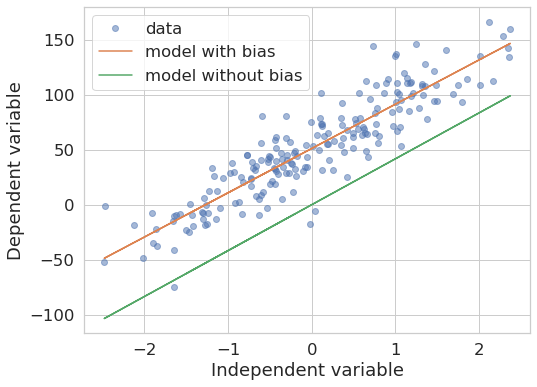

In [ ]:
plot_models_fit(x, y, model_with_bias, model_without_bias)

As we see, the two models produce different outcomes.
The one without bias "forces" the line to pass through the origin.
The slope may be similar because of ordinary least squares minimizes the vertical (square) distance from the line to the data points, but that really depends on the data at hand, as we can see in the following example with different ground truth data:

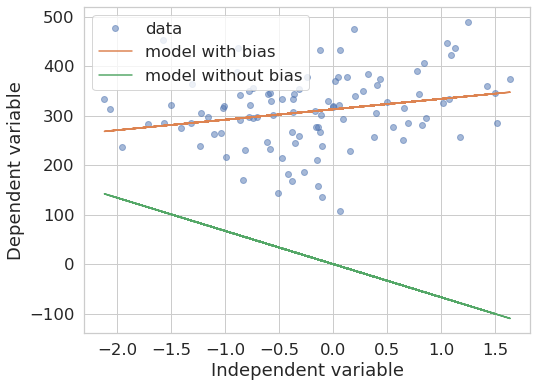

In [ ]:
x, y = make_regression(n_samples=100, n_features=1, bias=300, noise=80)

model_with_bias = LinearRegression().fit(x, y)   # default: fit_intercept=True
model_without_bias = LinearRegression(fit_intercept=False).fit(x, y)

plot_models_fit(x, y, model_with_bias, model_without_bias)

Finally, what if the data indeed does not have such a bias? Let's try it:

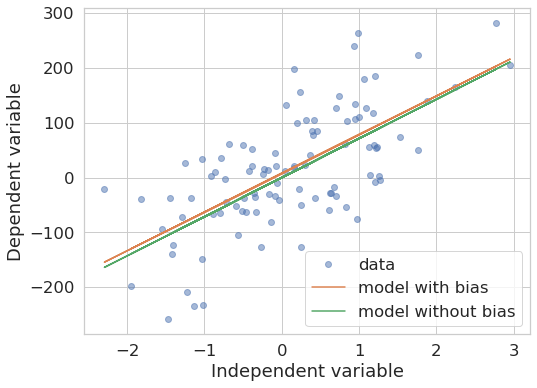

In [ ]:
x, y = make_regression(n_samples=100, n_features=1, bias=0, noise=80)

model_with_bias = LinearRegression().fit(x, y)   # default: fit_intercept=True
model_without_bias = LinearRegression(fit_intercept=False).fit(x, y)

plot_models_fit(x, y, model_with_bias, model_without_bias)

In general, the models indeed tend to become more similar (provided enough data points are given). 
But, again, the exact outcome depends on the data at hand.

## Take-home messages
- Excluding the bias constrains the parameters fit such that we will only get a similarly good (or bad) model compared to the one with bias *if the data happens to* not have such a bias.
- `scikit-learn`'s`LinearRegression` model fits the intercept per default. `statsmodels` `OLS` does not.
- Whenever in doubt in a situation like this, just try it out. Fake some data that you understand and run your own experiments.

<div style="text-align: right; font-size: 40px; font-family: 'Inconsolata', monospace;">
  /Fin
</div>
    
<div style="font-family: 'Inconsolata', monospace;">
Any bugs, questions, comments, suggestions? Ping me on [twitter](https://www.twitter.com/fabridamicelli) or drop me an e-mail (fabridamicelli at gmail).  
Share this article on your favourite platform:
</div>